# PubMed BERT Model + Attention Mechanism


In [2]:
# Cell 1: Imports and Setup
import os, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re

In [3]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


In [4]:
# Device setup
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"Using device: {device}")

Using device: mps


In [5]:
n_epochs = 5
learning_rate = 5e-6  # Smaller learning rate for PubMedBERT
batch_size = 4

In [6]:
# Create necessary directories for saving models and results
MODEL_DIR = "model"
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the base model directory
os.makedirs("results", exist_ok=True)

## 1. Read in Data 

In [7]:
# Load data
df = pd.read_csv('../data/processed/train_data.csv')
print(df.shape)
df.head()

(26235, 7)


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number
0,Q0TPM5,16825665,Skewed genomic variability in strains of the t...,"Clostridium perfringens is a Gram-positive, an...",NaN,Skewed genomic variability in strains of the t...,1
1,Q06904,16882723,A KaiC-associating SasA-RpaA two-component reg...,"KaiA, KaiB, and KaiC clock proteins from cyano...",autophosphorylation,A KaiC-associating SasA-RpaA two-component reg...,1
2,Q9MTL7,10852478,Complete nucleotide sequence of the Oenothera ...,"We describe the 159,443-bp [corrected] sequenc...",NaN,Complete nucleotide sequence of the Oenothera ...,1
3,Q9ZAH5,9756984,Sequence of the putative alanine racemase oper...,A gene cluster comprising the alanine racemase...,autolysis,Sequence of the putative alanine racemase oper...,1
4,P48308,7509368,Sequence and structural analysis of murine ade...,The genomic region encoding the major capsid p...,NaN,Sequence and structural analysis of murine ade...,1


## 2. Clean Data

In [8]:
# Download stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Standardized text preprocessing function for all models
    """
    # Handle NaN values
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    # Keep hyphens as they may be important in biomedical terms
    text = re.sub(r'[^\w\s-]', '', text)
    # Keep numbers that might be part of important terms
    text = " ".join([word.strip() for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning
print("Cleaning text...")
df['Text_Cleaned'] = df['Text_combined'].apply(preprocess_text)
df


Cleaning text...


,AC,PMID,Title,Abstract,Terms,Text_combined,batch_number,Text_Cleaned
0,Q0TPM5,16825665,Skewed genomic variability in strains of the t...,"Clostridium perfringens is a Gram-positive, an...",NaN,Skewed genomic variability in strains of the t...,1,skewed genomic variability strains toxigenic b...
1,Q06904,16882723,A KaiC-associating SasA-RpaA two-component reg...,"KaiA, KaiB, and KaiC clock proteins from cyano...",autophosphorylation,A KaiC-associating SasA-RpaA two-component reg...,1,kaic-associating sasa-rpaa two-component regul...
2,Q9MTL7,10852478,Complete nucleotide sequence of the Oenothera ...,"We describe the 159,443-bp [corrected] sequenc...",NaN,Complete nucleotide sequence of the Oenothera ...,1,complete nucleotide sequence oenothera elata p...
3,Q9ZAH5,9756984,Sequence of the putative alanine racemase oper...,A gene cluster comprising the alanine racemase...,autolysis,Sequence of the putative alanine racemase oper...,1,sequence putative alanine racemase operon stap...
4,P48308,7509368,Sequence and structural analysis of murine ade...,The genomic region encoding the major capsid p...,NaN,Sequence and structural analysis of murine ade...,1,sequence structural analysis murine adenovirus...
...,...,...,...,...,...,...,...,...
26230,G0FS62,11278540,Mutational analysis and reconstituted expressi...,To investigate a novel branch of the shikimate...,NaN,Mutational analysis and reconstituted expressi...,5,mutational analysis reconstituted expression b...
26231,P40957,10837255,"Complex formation between Mad1p, Bub1p and Bub...",The spindle checkpoint delays the metaphase to...,NaN,"Complex formation between Mad1p, Bub1p and Bub...",5,complex formation mad1p bub1p bub3p crucial sp...
26232,Q15303,10867024,Ligand discrimination in signaling through an ...,The epidermal growth factor (EGF)-like family ...,autophosphorylation,Ligand discrimination in signaling through an ...,5,ligand discrimination signaling erbb4 receptor...
26233,Q96RL1,23186163,Toward a comprehensive characterization of a h...,Mass spectrometry (MS)-based phosphoproteomics...,NaN,Toward a comprehensive characterization of a h...,5,toward comprehensive characterization human ca...


In [9]:
# Binarize the Terms column
print("Binarizing labels...")
df['Terms_List'] = df['Terms'].apply(
    lambda x: [term.strip() for term in str(x).split(',')] if pd.notna(x) and x != '' else []
)

# Initialize and fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(df['Terms_List'])

# Get the class names
label_columns = mlb.classes_
print(f"Found {len(label_columns)} unique labels: {label_columns}")

# Create a DataFrame with the binary labels
labels_df = pd.DataFrame(binary_labels, columns=label_columns)

# Save label columns for later use
with open('label_columns.json', 'w') as f:
    json.dump(list(label_columns), f)

# Keep only essential columns
df_cleaned = df[['batch_number', 'Text_Cleaned']].copy()
df_cleaned = pd.concat([df_cleaned, labels_df], axis=1)

print(f"Final cleaned data shape: {df_cleaned.shape}")


Binarizing labels...
Found 10 unique labels: ['autoactivation' 'autocatalysis' 'autofeedback' 'autoinduction'
 'autoinhibition' 'autokinase' 'autolysis' 'autophosphorylation'
 'autoregulation' 'autoubiquitination']
Final cleaned data shape: (26235, 12)


In [10]:
print(df_cleaned.shape)
df_cleaned.head()

(26235, 12)


,batch_number,Text_Cleaned,autoactivation,autocatalysis,autofeedback,autoinduction,autoinhibition,autokinase,autolysis,autophosphorylation,autoregulation,autoubiquitination
0,1,skewed genomic variability strains toxigenic b...,0,0,0,0,0,0,0,0,0,0
1,1,kaic-associating sasa-rpaa two-component regul...,0,0,0,0,0,0,0,1,0,0
2,1,complete nucleotide sequence oenothera elata p...,0,0,0,0,0,0,0,0,0,0
3,1,sequence putative alanine racemase operon stap...,0,0,0,0,0,0,1,0,0,0
4,1,sequence structural analysis murine adenovirus...,0,0,0,0,0,0,0,0,0,0


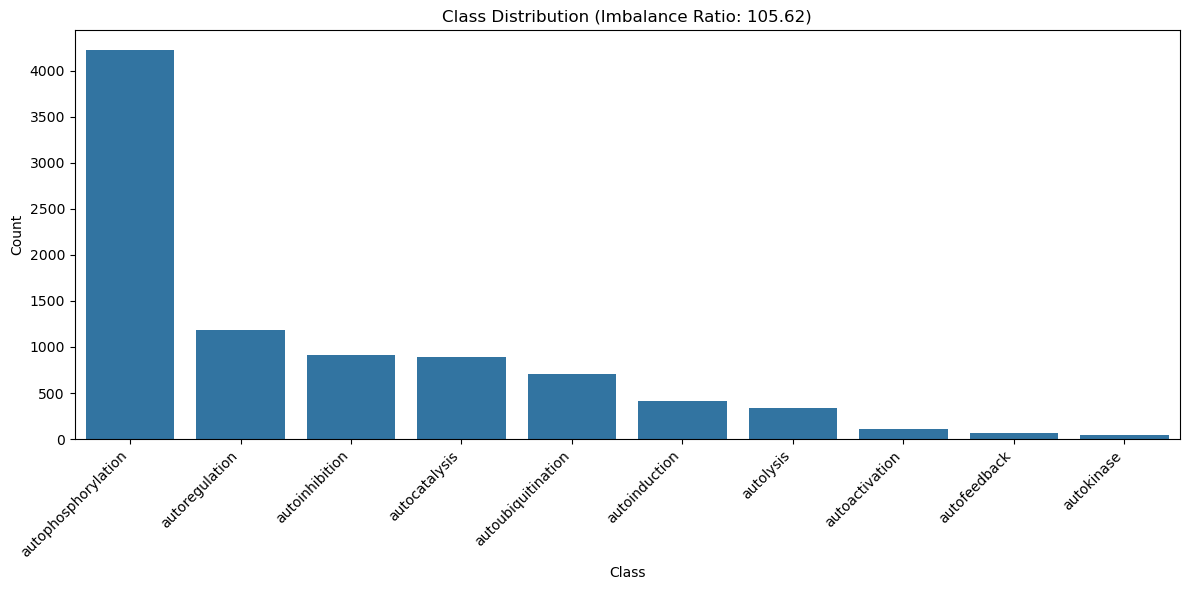

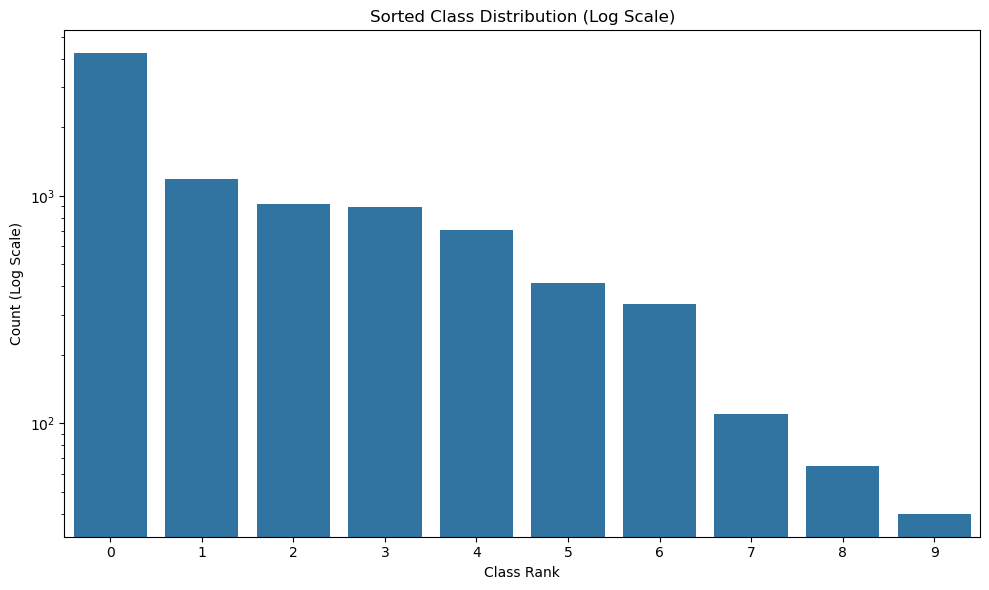

Total samples: 26235
Total classes: 10
Max class samples: 4225 (autophosphorylation)
Min class samples: 40 (autokinase)
Mean samples per class: 888.50
Median samples per class: 560.00
Imbalance ratio (max/min): 105.62

Multi-label statistics:
Average labels per sample: 0.34
Max labels per sample: 3

Samples by number of labels:
0 labels: 17490 samples (66.7%)
1 labels: 8620 samples (32.9%)
2 labels: 110 samples (0.4%)
3 labels: 15 samples (0.1%)


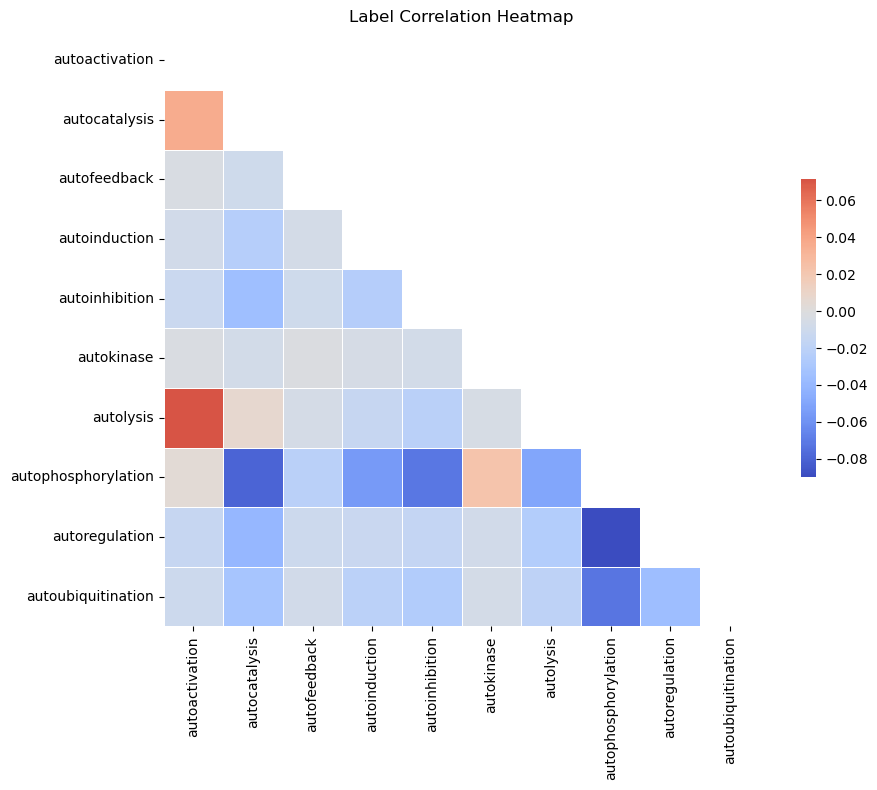


----- RECOMMENDATIONS FOR CLASS IMBALANCE -----
SEVERE IMBALANCE DETECTED:
- Focal Loss would be highly beneficial
- Consider using balanced sampling AND class weights
- Ensemble methods strongly recommended


In [11]:
# EDA for class imbalance analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def analyze_class_distribution(df, label_columns):
    """
    Analyze the distribution of classes in the dataset
    
    Args:
        df: DataFrame with binary labels
        label_columns: List of class column names
    """
    # Calculate class frequencies
    class_counts = df[label_columns].sum().sort_values(ascending=False)
    total_samples = len(df)
    
    # Create DataFrame for analysis
    class_stats = pd.DataFrame({
        'class': class_counts.index,
        'count': class_counts.values,
        'frequency': class_counts.values / total_samples,
        'ratio_to_max': class_counts.values / class_counts.max()
    }).sort_values('count', ascending=False).reset_index(drop=True)
    
    # Calculate imbalance metrics
    min_samples = class_counts.min()
    max_samples = class_counts.max()
    imbalance_ratio = max_samples / min_samples
    mean_samples = class_counts.mean()
    median_samples = class_counts.median()
    
    # Plot class distribution
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='class', y='count', data=class_stats)
    ax.set_title(f'Class Distribution (Imbalance Ratio: {imbalance_ratio:.2f})')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot sorted class distribution (log scale)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=np.arange(len(class_counts)), y=class_counts.values)
    ax.set_title('Sorted Class Distribution (Log Scale)')
    ax.set_xlabel('Class Rank')
    ax.set_ylabel('Count (Log Scale)')
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total samples: {total_samples}")
    print(f"Total classes: {len(label_columns)}")
    print(f"Max class samples: {max_samples} ({class_counts.idxmax()})")
    print(f"Min class samples: {min_samples} ({class_counts.idxmin()})")
    print(f"Mean samples per class: {mean_samples:.2f}")
    print(f"Median samples per class: {median_samples:.2f}")
    print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    # Check sample co-occurrences
    print("\nMulti-label statistics:")
    labels_per_sample = df[label_columns].sum(axis=1)
    print(f"Average labels per sample: {labels_per_sample.mean():.2f}")
    print(f"Max labels per sample: {labels_per_sample.max()}")
    
    # Display sample distribution by number of labels
    label_counts = labels_per_sample.value_counts().sort_index()
    print("\nSamples by number of labels:")
    for count, num_samples in label_counts.items():
        print(f"{count} labels: {num_samples} samples ({num_samples/total_samples:.1%})")
    
    # Plot correlation heatmap between labels
    plt.figure(figsize=(10, 8))
    corr = df[label_columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=False, center=0,
                square=True, linewidths=.5, cbar_kws={'shrink': .5})
    plt.title('Label Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Return the statistics for further analysis
    return class_stats

# Now run the analysis
class_stats = analyze_class_distribution(df_cleaned, label_columns)

# Print recommendations based on analysis
print("\n----- RECOMMENDATIONS FOR CLASS IMBALANCE -----")
max_min_ratio = class_stats['count'].max() / class_stats['count'].min()

if max_min_ratio > 100:
    print("SEVERE IMBALANCE DETECTED:")
    print("- Focal Loss would be highly beneficial")
    print("- Consider using balanced sampling AND class weights")
    print("- Ensemble methods strongly recommended")
elif max_min_ratio > 10:
    print("MODERATE IMBALANCE DETECTED:")
    print("- Your current class weights approach is good")
    print("- Consider adding Focal Loss for further improvement")
    print("- Balanced sampling could help with rare classes")
elif max_min_ratio > 3:
    print("MILD IMBALANCE DETECTED:")
    print("- Your current class weights approach should be sufficient")
    print("- Threshold optimization will help (already implemented)")
else:
    print("MINIMAL IMBALANCE DETECTED:")
    print("- Your current approach is appropriate")
    print("- Focus on model architecture and features")

# For small/rare classes
rare_classes = class_stats[class_stats['count'] < 30]['class'].tolist()
if rare_classes:
    print("\nVERY RARE CLASSES DETECTED:")
    print(f"These classes have fewer than 30 samples: {', '.join(rare_classes)}")
    print("Consider these options:")
    print("- Focal Loss with high gamma (3-5)")
    print("- Data augmentation for these specific classes")
    print("- Ensemble multiple models with different random seeds")